### SageMaker Stable diffusion Quick Kit - Inference 部署(ControlNet)
   [SageMaker Stable Diffusion Quick Kit](https://github.com/aws-samples/sagemaker-stablediffusion-quick-kit) 提供了一组开箱即用的代码、配置文件，它可以帮助客户在亚马逊云上使用Amazon SageMaker , Lambda, Cloudfront快速构建Stable diffusion AI绘图服务.
   
   ![架构](https://raw.githubusercontent.com/aws-samples/sagemaker-stablediffusion-quick-kit/main/images/architecture.png)


#### 前提条件
1. 亚马逊云账号
2. 建议使用ml.g4dn.xlarge/ml.g5.xlarge

### Notebook部署步骤
1. 升级boto3, sagemaker python sdk
2. 编译docker image
3. 部署AIGC推理服务
    * 配置模型参数
    * 配置异步推理
    * 部署SageMaker Endpoint 
4. 测试ControlNet模型
5. 清除资源


### 1. 升级boto3, sagemaker python sdk

In [1]:
!pip install --upgrade boto3 sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.5/706.5 kB 9.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 44.7 MB/s eta 0:00:0000:0100:01
  Created wheel for sagemaker: filename=sagemaker-2.143.0-py2.py3-none-any.whl size=948773 sha256=39074c9df7c5f2b8ff7c018abe099df6cea13c377d5b3826b2a9e33ed49bc95a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/84/6b/c7/7609620d9e78faf22307580cfe04dc6f8ec3cb1fad39f1d165
Successfully built sagemaker
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.71
    Uninstalling botocore-1.29.71:
      Successfully uninstalled botocore-1.29.71
  Attempting uninstall: boto3
    Found existing installation: boto3 1.26.71
    Uninstalling boto3-1.26.71:
      Successfully uninstalled bot

In [6]:
#导入对应的库

import re
import os
import json
import uuid

import numpy as np
import pandas as pd
from time import gmtime, strftime


import boto3
import sagemaker

from sagemaker import get_execution_role,session

role = get_execution_role()


sage_session = session.Session()
bucket = sage_session.default_bucket()
aws_region = boto3.Session().region_name


print(f'sagemaker sdk version: {sagemaker.__version__}\nrole:  {role}  \nbucket:  {bucket}')




sagemaker sdk version: 2.116.0
role:  arn:aws:iam::687912291502:role/sm-fs-streaming-agg-stack-SageMakerRole-PLMML6TNNEV2  
bucket:  sagemaker-us-west-2-687912291502


### 2. 编译docker image

In [ ]:
!./build_push.sh

### 3. 部署AIGC推理服务

#### 3.1 创建dummy model_data 文件(真正的模型使用code/infernece.py进行加载)

In [63]:
!touch dummy
!tar czvf model.tar.gz dummy sagemaker-logo-small.png
assets_dir = 's3://{0}/{1}/assets/'.format(bucket, 'stablediffusion')
model_data = 's3://{0}/{1}/assets/model.tar.gz'.format(bucket, 'stablediffusion')
!aws s3 cp model.tar.gz $assets_dir
!rm -f dummy model.tar.gz

dummy
tar: sagemaker-logo-small.png: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors
upload: ./model.tar.gz to s3://sagemaker-us-west-2-687912291502/stablediffusion/assets/model.tar.gz


#### 3.2 创建 model 配置

In [64]:

boto3_session = boto3.session.Session()
current_region=boto3_session.region_name

client = boto3.client("sts")
account_id=client.get_caller_identity()["Account"]

client = boto3.client('sagemaker')

#使用步骤2编译好的docker images
container = f'{account_id}.dkr.ecr.{current_region}.amazonaws.com/sd-inference-deepspeed'

model_data = f's3://{bucket}/stablediffusion/assets/model.tar.gz'


model_name = 'AIGC-Quick-Kit-' +  strftime("%Y-%m-%d-%H-%M-%S", gmtime())
role = get_execution_role()

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data,
    'Environment':{
        's3_bucket': bucket,
        #'model_name':'runwayml/stable-diffusion-v1-5', #默认为runwayml/stable-diffusion-v1-5
        'model_name':'s3://aigen-687912291502-us-west-2/models/model.tar.gz',
        #'control_net_enable':'True'
        #'deepspeed':'True'
    }
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container,


)

In [65]:
_time_tag = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
_variant_name =  'AIGC-Quick-Kit-'+ _time_tag
endpoint_config_name = 'AIGC-Quick-Kit-' +  _time_tag

response = client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'VariantName': _variant_name,
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.g5.xlarge',
            'InitialVariantWeight': 1
        },
    ]
    ,
    AsyncInferenceConfig={
        'OutputConfig': {
            'S3OutputPath': f's3://{bucket}/stablediffusion/asyncinvoke/out/'
        }
    }
)

#### 3.3 部署SageMaker endpoint

In [66]:
endpoint_name = f'AIGC-Quick-Kit-{str(uuid.uuid4())}'


response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
    
)



print(f'终端节点:{endpoint_name} 正在创建中，首次启动中会加载模型，请耐心等待, 请在控制台上查看状态')


终端节点:AIGC-Quick-Kit-70ee09e4-ed77-42af-b742-a442a4a8869d 正在创建中，首次启动中会加载模型，请耐心等待, 请在控制台上查看状态


### 4. ControlNet 测试

### 4.1 辅助方法 

In [60]:
import time
import uuid
import io
import traceback
from PIL import Image


s3_resource = boto3.resource('s3')

def get_bucket_and_key(s3uri):
    pos = s3uri.find('/', 5)
    bucket = s3uri[5 : pos]
    key = s3uri[pos + 1 : ]
    return bucket, key


def predict_async(endpoint_name,payload):
    runtime_client = boto3.client('runtime.sagemaker')
    input_file=str(uuid.uuid4())+".json"
    s3_resource = boto3.resource('s3')
    s3_object = s3_resource.Object(bucket, f'stablediffusion/asyncinvoke/input/{input_file}')
    payload_data = json.dumps(payload).encode('utf-8')
    s3_object.put( Body=bytes(payload_data))
    input_location=f's3://{bucket}/stablediffusion/asyncinvoke/input/{input_file}'
    print(f'input_location: {input_location}')
    response = runtime_client.invoke_endpoint_async(
        EndpointName=endpoint_name,
        InputLocation=input_location
    )
    result =response.get("OutputLocation",'')
    wait_async_result(result)


def s3_object_exists(s3_path):
    """
    s3_object_exists
    """
    try:
        s3 = boto3.client('s3')
        base_name=os.path.basename(s3_path)
        _,ext_name=os.path.splitext(base_name)
        bucket,key=get_bucket_and_key(s3_path)
        
        s3.head_object(Bucket=bucket, Key=key)
        return True
    except Exception as ex:
        print("job is not completed, waiting...")   
        return False
    
def draw_image(output_location):
    try:
        bucket, key = get_bucket_and_key(output_location)
        obj = s3_resource.Object(bucket, key)
        body = obj.get()['Body'].read().decode('utf-8') 
        predictions = json.loads(body)
        print(predictions['result'])
        for image in predictions['result']:
            bucket, key = get_bucket_and_key(image)
            obj = s3_resource.Object(bucket, key)
            bytes = obj.get()['Body'].read()
            image = Image.open(io.BytesIO(bytes))
            #resize image to 50% size
            half = 0.5
            out_image = image.resize( [int(half * s) for s in image.size] )
            out_image.show()
    except Exception as e:
        print("result is not completed, waiting...")   
    

    
def wait_async_result(output_location,timeout=60):
    current_time=0
    while current_time<timeout:
        if s3_object_exists(output_location):
            print("have async result")
            draw_image(output_location)
            break
        else:
            time.sleep(5)

            
def check_sendpoint_status(endpoint_name):
    client = boto3.client('sagemaker')
    response = client.describe_endpoint(
        EndpointName=endpoint_name
    )
    if response['EndpointStatus'] !='InService':
        raise Exception (f'{endpoint_name} not ready , please wait....')
    else:
        status = response['EndpointStatus']
        print(f'{endpoint_name} is ready, status: {status}')

#### 检查endpoint 状态

In [61]:
check_sendpoint_status(endpoint_name)

AIGC-Quick-Kit-161e2a7c-c7a2-47d8-ae12-2cfe43ab29a7 is ready, status: InService


4.0 Basic txt2image 测试

In [62]:
#AIGC Quick Kit txt2img
inputs_txt2img = {
    "prompt": "callie, inkling, splatoon, cute, forest background",
    "negative_prompt":"(worst quality, low quality:1.4), simple background",
    "steps":20,
    "sampler":"euler_a",
    "seed": 52362,
    "height": 512, 
    "width": 512,
    "count":2

}
start=time.time()
predict_async(endpoint_name,inputs_txt2img)
print(f"Time taken: {time.time() - start}s")

input_location: s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/input/7803d610-2a7d-46bc-9e4a-bfb15fda4cac.json
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...


KeyboardInterrupt: 

### 4.1 Canny 测试



input_location: s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/input/01df914c-958e-44de-b9e1-2751d9de20cd.json
job is not completed, waiting...
job is not completed, waiting...
have async result
['s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/900533c0-c4d1-4cb1-a277-9d2bd2efa501.jpg', 's3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/d6e37e3d-fb55-4d5f-8412-039ce0d8ca90.jpg']


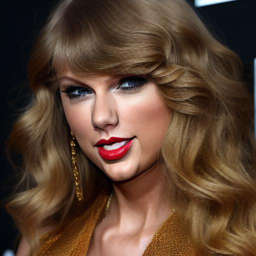

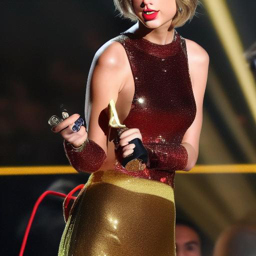

In [44]:

payload={
                "prompt": "taylor swift, best quality, extremely detailed",
                "negative_prompt":"monochrome, lowres, bad anatomy, worst quality, low quality",
                "steps":20,
                "sampler":"euler_a",
                "seed":43768,
                "height": 512, 
                "width": 512,
                "count":2,
                "control_net_model":"canny",
                "input_image":"https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
}

predict_async(endpoint_name,payload)


### 4.2 Openpose 测试

input_location: s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/input/4b87c7a0-7f32-4b40-9cfd-0509be35a734.json
job is not completed, waiting...
job is not completed, waiting...
have async result
['s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/b48a6256-e05e-4e62-a27a-4d999f329dc6.jpg', 's3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/689b2d92-7d1f-46a0-b9fc-99ce031b1eb3.jpg']


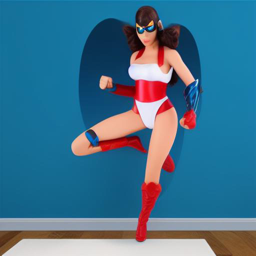

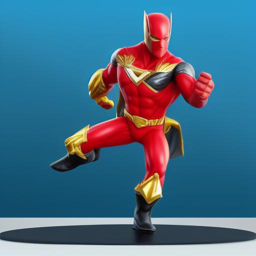

In [45]:
payload={
                    "prompt": "super-hero character, best quality, extremely detailed",
                    "negative_prompt":"monochrome, lowres, bad anatomy, worst quality, low quality",
                    "steps":20,
                    "sampler":"euler_a",
                    "seed":43768,
                    "height": 512,
                    "width": 512,
                    "count":2,
                    "control_net_model":"openpose",
                    "input_image":"https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/yoga1.jpeg"
}
predict_async(endpoint_name,payload)

### 4.3 mlsd 测试

input_location: s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/input/19ebd607-6557-4592-a557-02bd618ff7f7.json
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
have async result
['s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/480d3991-6ee7-42ae-9e64-6c6a1a5d47b6.jpg', 's3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/afef7d88-23f2-42a9-ba82-43de2eab20f8.jpg', 's3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/9e58b7bb-bc61-49d6-bf93-4b9be4ce28a6.jpg']


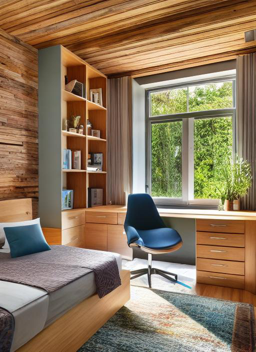

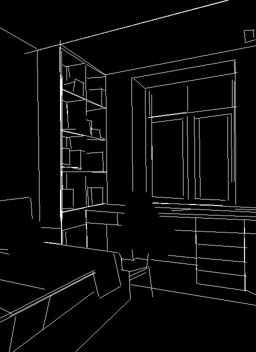

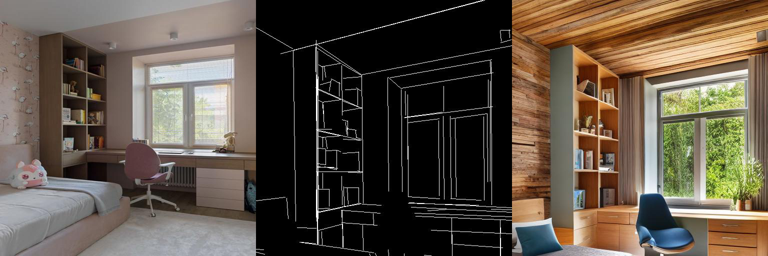

In [35]:
payload={
                    "prompt": "room",
                    "negative_prompt":"monochrome, lowres, bad anatomy, worst quality, low quality",
                    "steps":20,
                    "sampler":"euler_a",
                    "seed":43768,
                    "height": 512,
                    "width": 512,
                    "count":2,
                    "control_net_model":"mlsd",
                    "input_image":"https://huggingface.co/lllyasviel/sd-controlnet-mlsd/resolve/main/images/room.png"
}
predict_async(endpoint_name,payload)

### 4.4 depth 测试

input_location: s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/input/de169494-ad0a-4fd4-833f-41fd037cdda0.json
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
have async result
['s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/b34ab207-502b-43d5-bb4f-b92132fd3f98.jpg', 's3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/7a05f34d-a4e1-440e-a1f0-7987b089a06a.jpg', 's3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/d01a327a-49f6-4961-8a33-0d790349d977.jpg']


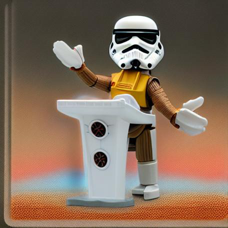

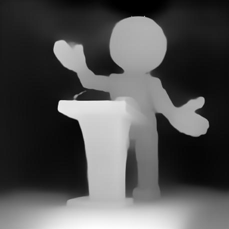

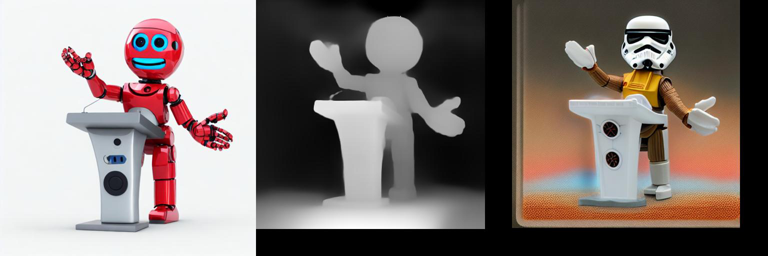

In [23]:
payload={
                    "prompt": "Stormtrooper's lecture",
                    "negative_prompt":"monochrome, lowres, bad anatomy, worst quality, low quality",
                    "steps":20,
                    "sampler":"euler_a",
                    "seed":43768,
                    "height": 512,
                    "width": 512,
                    "count":2,
                    "control_net_model":"depth",
                    "input_image":"https://huggingface.co/lllyasviel/sd-controlnet-depth/resolve/main/images/stormtrooper.png"
                }
predict_async(endpoint_name,payload)

### 4.5 hed 测试

input_location: s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/input/69f7b671-f4cc-4e16-b698-45a5ac07aecb.json
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
have async result
['s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/efe1be31-4692-45b8-9937-0860bd7ce0f0.jpg', 's3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/2403eaf3-5a0b-45d8-a243-f0be0717711d.jpg', 's3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/3cc865b7-4e5f-435c-af21-f18b55bf4ab1.jpg']


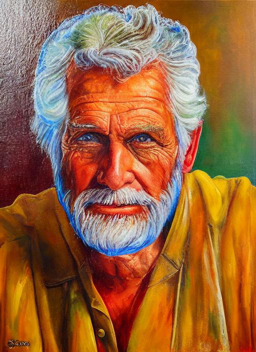

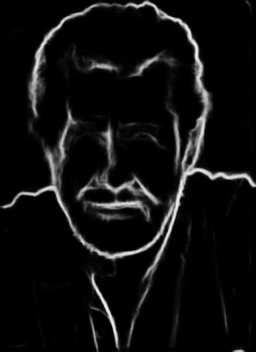

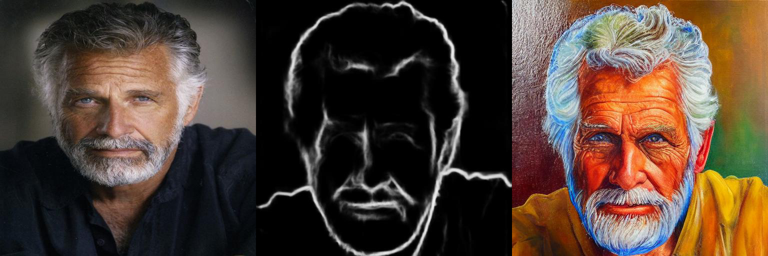

In [24]:
 payload={
                    "prompt": "oil painting of handsome old man, masterpiece",
                    "negative_prompt":"monochrome, lowres, bad anatomy, worst quality, low quality",
                    "steps":20,
                    "sampler":"euler_a",
                    "seed":43768,
                    "height": 512,
                    "width": 512,
                    "count":2,
                    "control_net_model":"hed",
                    "input_image":"https://huggingface.co/lllyasviel/sd-controlnet-hed/resolve/main/images/man.png"
                }
predict_async(endpoint_name,payload)

### 4.6 scribble 测试

input_location: s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/input/fe0db358-3787-4428-84d7-5922ac1277d2.json
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
have async result
['s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/2c4d4b28-17f3-4936-aac2-86e8a9eb66bf.jpg', 's3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/d0fb29dd-52c0-45a8-bb0d-1e8512dee878.jpg', 's3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/images/d42efc02-0a54-464e-a202-3efbad4f1f04.jpg']


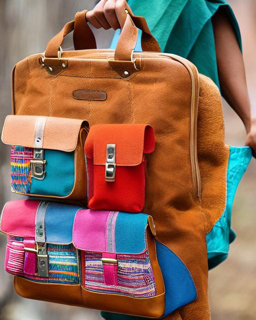

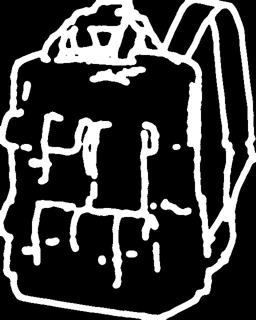

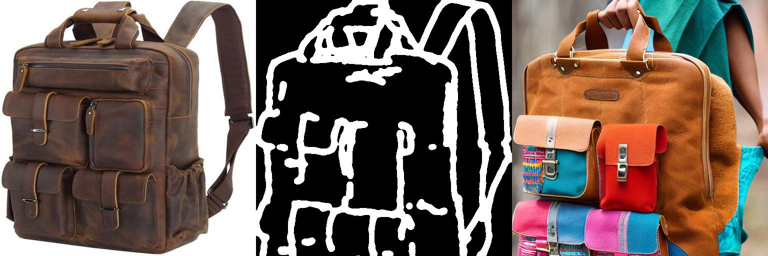

In [25]:
payload={
                    "prompt": "bag",
                    "negative_prompt":"monochrome, lowres, bad anatomy, worst quality, low quality",
                    "steps":20,
                    "sampler":"euler_a",
                    "seed":43768,
                    "height": 512,
                    "width": 512,
                    "count":2,
                    "control_net_model":"scribble",
                    "input_image":"https://huggingface.co/lllyasviel/sd-controlnet-scribble/resolve/main/images/bag.png"
          }
predict_async(endpoint_name,payload)

### 5 清除资源

In [ ]:
response = client.delete_endpoint(
    EndpointName=endpoint_name
    
)

response = client.delete_endpoint_config(
    EndpointConfigName=endpoint_config_name
)


print(f'终端节点:{endpoint_name} 已经被清除，请在控制台上查看状态')
